In [19]:
#imports
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *

In [ ]:
####################################################################################################### 
#(RUN ONLY IF NEEDED) 
#Obtain 1-normalized laplacian eigenvalues & eigenvectors from Selen's data and save them to file

f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
Adjacency = sparse.csc_matrix( (f['combined']['A']['data'], f['combined']['A']['ir'], f['combined']['A']['jc']) ).toarray()
CC = np.asarray(f['CC']['restInds'], dtype=int)
#Laplacian = sparse.csc_matrix( (f['combined']['L']['data'], f['combined']['L']['ir'], f['combined']['L']['jc']) ).toarray()
#Degree = sparse.csc_matrix( (f['combined']['DegreeM']['data'], f['combined']['DegreeM']['ir'], f['combined']['DegreeM']['jc']) ).toarray()
f.close()
indices = np.array([elem[0] for elem in CC])-1
Adjacency = Adjacency[indices,:]
Adjacency = Adjacency[:,indices]
Deg=np.sum(Adjacency, axis=0)
sqrt_Deg=np.power(Deg,-0.5)
Degree_Matrix=sp.sparse.diags(Deg)
sqrt_Degree_Matrix=sp.sparse.diags(sqrt_Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(Adjacency)
Laplacian = (sp.sparse.csc_matrix.dot(sqrt_Degree_Matrix,sp.sparse.csc_matrix.dot(regLap,sqrt_Degree_Matrix))).toarray()
Laplacian[Laplacian>1]=1

eigenvalues2, eigenvectors2 = np.linalg.eigh(Laplacian)
#eigenvectors2 matrix: each COLUMN eigenvectors2[:,i] is a normalized eigenvector

#do we want to set the first eigenvalues to the known value, which should be zero?
#eigenvalues2[0] = 0
#1-norm normalization
for col in range(eigenvectors2.shape[1]):
    eigenvectors2[:,col]/=np.sum(eigenvectors2[:,col])


#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals.npy', eigenvalues2)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy', eigenvectors2)


In [2]:
#If known, read eigenvalues and eigenvectors from file
eigenvalues2 = np.load('../data/eigvals.npy')
#eigenvectors2 = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')

In [3]:
#Set parameters and bounds for minimization algorithms
aEE, bnds_aEE = 50, (0,500)
aIE, bnds_aIE = 50, (0,500)
aEI, bnds_aEI = 100, (0,500)
aII, bnds_aII = 10, (0,500)
dE, bnds_dE = 0.3, (0,20)
dI, bnds_dI = 0.6, (0,20)
P, bnds_P = 0, (0,10)
Q, bnds_Q = 0, (0,10)
sEE, bnds_sEE = 60, (0,500)
sIE, bnds_sIE = 114, (0,500)
sEI, bnds_sEI = 150, (0,500)
sII, bnds_sII = 20, (0,500)
#D, bnds_D = 1, (1,1)             #unchanged
#tE, bnds_tE = 1, (0,10)          #unchanged
#tI, bnds_tI = 1, (0,10)          #unchanged
#snE, bnds_snE = 1, (1,1)        #unchanged
#snI, bnds_snI = 1, (1,1)         #unchanged

initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII]) #,D,tE,tI,snE,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII] #,bnds_D,bnds_tE,bnds_tI,bnds_snE,bnds_snI]

Graph_Kernel='Gaussian'
first_k=2
True_Spectrum = 15*(np.arange(first_k,5000)**(-0.3))
LSA=True
Visual=True
SaveFiles=False
FilePath=' '

Args = (eigenvalues2, Graph_Kernel, True_Spectrum, first_k, LSA, Visual, SaveFiles)

3 unique steady states were found
Stable
Unstable: no oscillations
Stable
Best (stable) steady state: 0, with Ess=0.0 Iss=0.2, Distance: 50.436


50.43555683876321

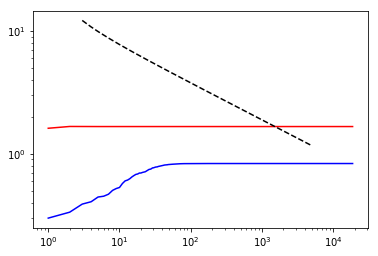

In [21]:
############################
#single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
Full_Analysis(initial_guess, eigenvalues2, Graph_Kernel, True_Spectrum, first_k, LSA, Visual, SaveFiles, FilePath)

In [ ]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000

#initial_guess=better_result['x']
result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='Nelder-Mead',#'L-BFGS-B', 
                              bounds=bnds, 
                              tol=1e-08)
                             # options={'maxiter':2000})

In [ ]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations

new_initial_guess=result['x']

#sort of ugly, but need to defind bounds manually for basinhopping
class MyBounds(object):
    def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

mybounds = MyBounds()

minimizer_kwargs={'args':Args, 'method':'Nelder-Mead', 'bounds':bnds}#, 'tol':1e-09}#, 'options':{'maxiter':200}}

better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=30, stepsize=3,
                                  minimizer_kwargs=minimizer_kwargs,
                                  accept_test=mybounds)

initial_guess=better_result['x']

In [ ]:
#re-analyze result of minimization procedure
SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
SStates       

SSnr=0

Tr, Det, Jk = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues2, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=1.0, tau_e=1.0, tau_i=1.0,)    


Gmatrix = Graph_WC_SpatialPowerSpectrum(Laplacian_eigenvalues=eigenvalues2, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1.0, tau_e=1.0, tau_i=1.0,
                                        sigma_noise_e=1.0, sigma_noise_i=1.0,
                                        Visual=True)

In [22]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results (any parameter set; grid laplacian only):
#(can choose parameter set from 2015 paper, sort of. do we wanna parametrize the sigmoid?)
#simulate (with no noise) on a grid to verify that steady state solution is correct (start directly from SS solution).
#test for stability/instability/oscillations result by adding noise in the grid simulation
#calculate linearized-model PS for grid-Laplacian; run noisy grid simulation and calculate PS (see handwritten notes) compare the two
#
################################################################################################
#testing the correctness of the full parameter fit (minimization) algorithm result
#(intended mainly for the (cortical) better_result parameter set)
#
#check via effect on linearized Jk eigenvalues if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set